# Structural Similarity

## Similarity metrics on Game Of Thrones characters' interactions data

First, to compute different similarity metrics for the data was needed, to see how nodes are structurally similar to each other (means they share a lot off neighbors).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
%matplotlib inline

In [2]:
events = pd.read_csv('events.csv')
characters = pd.read_csv('characters.csv')

kill_events = events[events['event'] == 'killed']
kill_events = pd.DataFrame(kill_events, index = None, columns=['characterID', 'event', 'withID'])
kill_events = kill_events.dropna()

G = nx.DiGraph()

for row, data in kill_events.iterrows():
    killer = data[2]
    killed = data[0]
    G.add_edge(killer, killed)

In [3]:
import scipy.sparse as spr
import scipy.spatial as spt

In [4]:
A = nx.adjacency_matrix(G)

In [5]:
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)

To get better looking graphs with clearer patterns -- if there is any -- it is adviced to re-order nodes in the graph adjacency matrix first. To do so one can use Cuthill–McKee algorithm that make a relabeling of the vertices of the graph to reduce the bandwidth of the adjacency matrix.

In [6]:
from scipy.sparse import csr_matrix
A_spr = csr_matrix(A)

In [7]:
cm_ordering = spr.csgraph.reverse_cuthill_mckee(A_spr)

A_spr = A_spr[np.ix_(cm_ordering, cm_ordering)]

In [8]:
A = nx.to_numpy_matrix(nx.from_scipy_sparse_matrix(A_spr), dtype=int)
A = np.asarray(A)

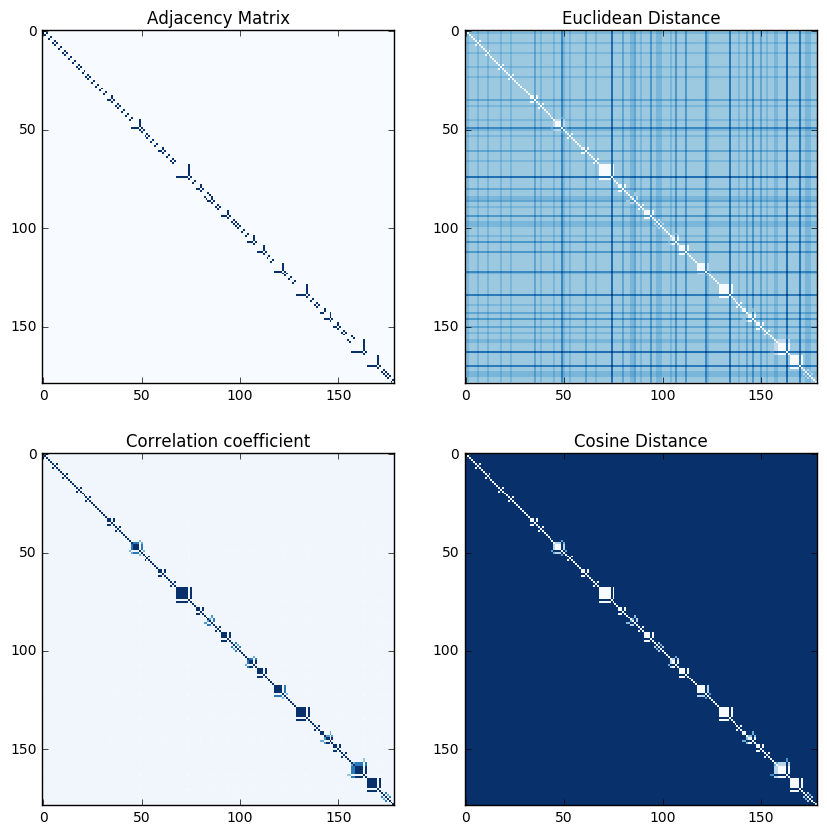

In [9]:
f, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0, 0].imshow(A, cmap = 'Blues', interpolation = 'None')
ax[0, 0].set_title('Adjacency Matrix')

dVec = spt.distance.pdist(A, metric = 'euclidean')
D = spt.distance.squareform(dVec)
ax[0, 1].imshow(D, cmap = 'Blues', interpolation = 'None')
ax[0, 1].set_title('Euclidean Distance')

D = np.corrcoef(A)
ax[1, 0].imshow(D, cmap = 'Blues', interpolation = 'None')
ax[1, 0].set_title('Correlation coefficient')

dVec = spt.distance.pdist(A, metric = 'cosine')
D = spt.distance.squareform(dVec)
ax[1, 1].imshow(D, cmap = 'Blues', interpolation = 'None')
ax[1, 1].set_title('Cosine Distance')

plt.show()

1. Euclidean distance is the number of neighbors that differ between two nodes.
2. Correlation coefficient compares the actual number of common neighbors with the expected in a completely random network.
3. Cosine similarity takes into account numbers of common neightbors related to nodes' degrees.

Thus according to these definitions of the metrics, all of them shows similar results. Their shape also correlates with the initial adjacency matrix, i.e. nodes have bigger similarity in bigger connected chuncks of the matrix.
By looking at these graphs one might think that there are some a few bigger and some smaller communities in the data present.

## Temporal network

In the following task I used a network of interactions on the stack exchange web site Math Overflow. Graph were constructed from the Stack Exchange Data Dump. (Info from snap.stanford.edu)

The data file contains lines in the form: $out\_id$  $in\_id$  $time$. The time variables from $1254192988$ to $1457262355$. So I do not go through the file more than once I manually divided the time interval into 20 smaller intervals and parsed the file according to these intervals.

In [10]:
start = 1254192988
finish = 1457262355
number_of_steps = 20
step = (finish - start) / number_of_steps

milestones = [finish - i * step for i in range(1, number_of_steps)]

In [11]:
# adds value to the list in a dictionary
def add_to_dict(dictionary, key, value):
    if key in dictionary.keys():
        dictionary[key].append(value)
    else:
        dictionary[key] = [value]

In [12]:
# to store the data divided on time intervals
temporal_info = dict()

file = open("sx-mathoverflow.txt")
for line in file:
    data = line.split()
    for i in range(len(milestones)):
        if int(data[2]) >= milestones[i]:
            edge = str(line.rsplit(' ', 1)[0])
            add_to_dict(temporal_info, key = i, value = edge)

In [20]:
G_list = []
G = nx.DiGraph()
for i in range(len(temporal_info)):
    new_G = nx.parse_edgelist(temporal_info[i], create_using = nx.DiGraph(), nodetype = int)
    G = nx.compose(G, new_G) # add new edges to the graph
    G_list.append(G)

In [21]:
assortativity_list = [nx.degree_pearson_correlation_coefficient(G_list[i])
                     for i in range(len(G_list))]

In [22]:
print ''.join('%5.3f\n' % v for v in assortativity_list)

-0.018
-0.035
-0.050
-0.061
-0.073
-0.080
-0.087
-0.093
-0.099
-0.105
-0.110
-0.115
-0.117
-0.119
-0.123
-0.125
-0.129
-0.130
-0.133



From such results one might conclude that the data isn't the best for studying social networks, as usually they tend to show high assortativity (edges are more likely to form between nodes with similar degree) and here the network starts with the coefficient relatively close to zero. But in some ways it is an interesting example which indicates that in particular settings social networks are not necessarily with high assortativity.

Moreover, as times go on, the coefficient keep decreasing.

If to speculate on possible reasons of such an 'abnormal' behaviour, I'd propose the following:

The networks of StackExchange forums are different from the networks in Facebook and alike. Being a user of the site, one hardly sees on how many friends other users have, or whether they know each other. It more about people helping each other with any questions one is able to answer. And as time goes by, more newcomers show up with beginner level questiongs, and more of 'old' users are getting more expirienced in the field and are willing to help these with little numbers of 'interactions'.

## Biological network

Protein Interaction Network, data for yeast (http://www3.nd.edu/~networks/resources.htm). 

In [16]:
b_G = nx.read_edgelist("bo.dat",create_using=nx.Graph(), nodetype = int)

In [17]:
degrees = b_G.degree()

In [18]:
import operator
sorted_degrees = sorted(degrees.items(), key=operator.itemgetter(1), reverse=True)

In [19]:
assort_list = []
assort_list.append(nx.degree_assortativity_coefficient(b_G))
for i in range(8):
    b_G.remove_node(sorted_degrees[i][0])
    assort_list.append(nx.degree_pearson_correlation_coefficient(b_G))
    
print(assort_list)

[-0.15677830525143321, -0.13080593804140586, -0.14142348408213021, -0.14154139742350216, -0.12849161565699899, -0.13183260517595924, -0.1308264585301589, -0.11353886977482441, -0.10502520457862469]


Biological networks in principle show disassortative mixing and this one isn't an exception.
And while one extracts nodes with higher degrees one by one from the network, the assortativity coefficient starts to increase slightly but surely. It can be explained by the fact that the nodes are being removed are most influencial on the network structure, since they have more connections.